In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import colormaps  



In [2]:
# LOAD INTERMEDIATE DATA

# # # User input: session folder
session_folder = "/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14"

# Build paths
intermediate_dir = Path(session_folder) / "intermediate_data"
movements_path = intermediate_dir / "tongue_movs.parquet"
df_trials_path = intermediate_dir / "nwb_df_trials.parquet"
df_licks_path = intermediate_dir / "nwb_df_licks.parquet"

# Load dataframes
tongue_movements = pd.read_parquet(movements_path)
df_trials = pd.read_parquet(df_trials_path)
df_licks = pd.read_parquet(df_licks_path)


print(tongue_movements.columns)

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event'],
      dtype='object')


In [4]:
# example: time of first tongue movement on each trial:
df = tongue_movements.copy()

# Get first start_time per trial
first_start_times = df.groupby('trial', as_index=False).nth(0)[['trial', 'start_time']]

print(first_start_times)


      trial   start_time
20      0.0     0.190304
48      1.0    13.650272
88      2.0    29.780192
142     3.0    63.880128
220     4.0   136.206016
...     ...          ...
7232  581.0  5291.530560
7236  582.0  5297.304576
7238  583.0  5307.098528
7240  584.0  5314.612512
7243  585.0  5321.664512

[568 rows x 2 columns]


In [5]:
# example: whether first tongue movement is a lick (would be a cue response lick)
# Group by trial and get the first movement row for each trial
df = tongue_movements.copy()

first_movements = df.groupby('trial').nth(0).reset_index()

# Select only the trial, has_lick, and cue_response columns
first_movement_licks = first_movements[['trial', 'has_lick', 'cue_response']]
print(first_movement_licks)
#NB: cue_response == None means there was no lick detected by lickometer.

# # Sanity check: Find rows where has_lick is False and cue_response is True (should never happen)
# violation_rows = first_movement_licks[(first_movement_licks['has_lick'] == False) & (first_movement_licks['cue_response'] == True)]
# print(violation_rows)


     trial  has_lick cue_response
0      0.0     False         None
1      1.0      True         True
2      2.0     False         None
3      3.0     False         None
4      4.0     False         None
..     ...       ...          ...
563  581.0      True         True
564  582.0      True         True
565  583.0      True         True
566  584.0      True         True
567  585.0      True         True

[568 rows x 3 columns]


In [6]:
# example analysis

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements

def annotate_movement_timing(tongue_movements: pd.DataFrame,
                             df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate each movement with trial-relative metrics and
    invalidate any movement that spans a go-cue boundary.

    New columns (nullable):
      • movement_number_in_trial       Int64  
      • cue_response_movement_number   Int64  
      • movement_before_cue_response   boolean  
      • movement_latency_from_go       Float64  
      • lick_latency                   Float64 (lick_time - go cue time)

    Pre-trial or spanning movements keep all-new as NA.
    """

    # --- Sanity checks ---
    required_cols = {'trial', 'start_time', 'end_time', 'cue_response', 'lick_time'}
    missing = required_cols - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing columns in tongue_movements: {missing}")
    if not {'trial', 'goCue_start_time_in_session'}.issubset(df_trials):
        raise ValueError("df_trials must contain 'trial' and 'goCue_start_time_in_session'")

    df = tongue_movements.copy()

    # --- Null-out any movement spanning a go-cue ---
    go_times = df_trials['goCue_start_time_in_session']
    uniq = df[['movement_id', 'start_time', 'end_time']].drop_duplicates()
    bad_ids = {
        m for m, s, e in uniq.itertuples(index=False)
        if ((go_times > s) & (go_times < e)).any()
    }
    df.loc[df['movement_id'].isin(bad_ids), 'trial'] = pd.NA

    # --- Map go-cue times onto each movement row ---
    go_map = df_trials.set_index('trial')['goCue_start_time_in_session']
    df['goCue_start_time_in_session'] = df['trial'].map(go_map)

    # --- Validate ordering by (trial, start_time) ---
    valid_trials = df['trial'].dropna()
    if not valid_trials.is_monotonic_increasing:
        raise ValueError("Trials not in ascending order")
    within_trial_sorted = (
        df.dropna(subset=['trial'])
          .groupby('trial', sort=False)['start_time']
          .apply(lambda x: x.dropna().is_monotonic_increasing)
          .all()
    )
    if not within_trial_sorted:
        raise ValueError("start_time not monotonic within trial")

    # --- Annotate movement timing ---
    df['movement_number_in_trial'] = df.groupby('trial').cumcount() + 1
    df['cue_response_movement_number'] = (
        df.groupby('trial')['movement_number_in_trial']
          .transform(lambda m: m.where(df.loc[m.index, 'cue_response']).max())
    )
    df['movement_before_cue_response'] = (
        df['movement_number_in_trial'] < df['cue_response_movement_number']
    )
    df['movement_latency_from_go'] = (
        df['start_time'] - df['goCue_start_time_in_session']
    ).where(df['start_time'] >= df['goCue_start_time_in_session'])

    # --- Compute lick latency (lick_time - go cue time, only for cue_response trials) ---
    lick_latency_map = (
        df.loc[df['cue_response'] == True]
          .set_index('trial')
          .eval('lick_time - goCue_start_time_in_session')
          .rename('lick_latency')
    )
    df['lick_latency'] = df['trial'].map(lick_latency_map)

    # --- Cast to nullable dtypes ---
    df = df.astype({
        'movement_number_in_trial':       'Int64',
        'cue_response_movement_number':   'Int64',
        'movement_before_cue_response':   'boolean',
        'movement_latency_from_go':       'Float64',
        'lick_latency':                   'Float64'
    })

    # --- Blank out all new annotations for pre-trial or invalid rows ---
    is_pre = df['trial'].isna()
    df.loc[is_pre, [
        'movement_number_in_trial',
        'cue_response_movement_number',
        'movement_before_cue_response',
        'movement_latency_from_go',
        'lick_latency'
    ]] = pd.NA

    return df


# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


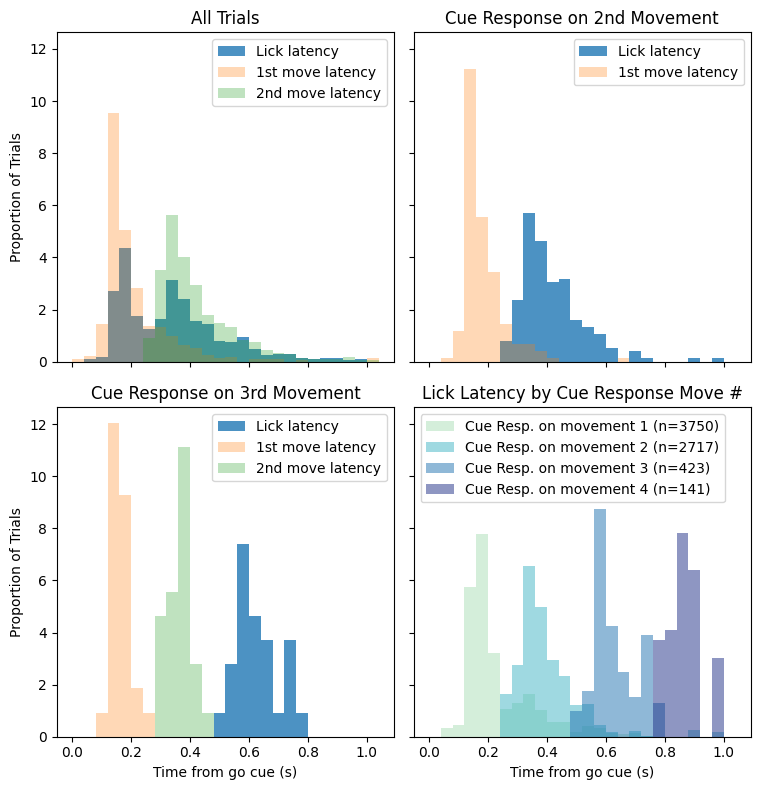

In [7]:
# plotting results: latency of cue response tongue movements, sorted by movement ordinal

# --- Shared settings ---
bins = np.arange(0, 1.05, 0.04)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# -------------------------------
# Subplot 1: All trials
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="All Trials", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 2: Cue response on 2nd movement
# -------------------------------
trials_2nd = df.loc[df['cue_response_movement_number'] == 2, 'trial'].unique()
df_2nd = df.query("trial in @trials_2nd and movement_number_in_trial <= 2")

lick_lat = df_2nd['lick_latency']

moves = (
    df_2nd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']

ax = axes[1]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.set(title="Cue Response on 2nd Movement")
ax.legend()

# -------------------------------
# Subplot 3: Cue response on 3rd movement
# -------------------------------
trials_3rd = df.loc[df['cue_response_movement_number'] == 3, 'trial'].unique()
df_3rd = df.query("trial in @trials_3rd and movement_number_in_trial <= 3")

lick_lat = df_3rd['lick_latency']

moves = (
    df_3rd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[2]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="Cue Response on 3rd Movement", xlabel="Time from go cue (s)", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 4: Lick latency by cue_response_movement_number (1-4)
# -------------------------------
lick_latencies_by_cue = (
    df.dropna(subset=['lick_latency'])
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

cmap = plt.colormaps['YlGnBu']
colors = cmap(np.linspace(0.3, 0.9, 4))

ax = axes[3]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True, alpha=0.5,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})",
        color=colors[n-1]
    )
ax.set(title="Lick Latency by Cue Response Move #", xlabel="Time from go cue (s)")
ax.legend(loc="upper left")

# --- Final layout ---
fig.tight_layout()
plt.show()



